We can use SVD to calculate a projection of a dataset and select a number of dimensions or principal components of the projection to use as input to a model.

The scikit-learn library provides the TruncatedSVD class that can be fit on a dataset and used to transform a training dataset and any additional dataset in the future.

## example - iris dataset

In [24]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
RANDOM_STATE = 2

iris = datasets.load_iris()

print("features: ", iris.feature_names)
print("iris keys: ", iris.keys())

# X = features values for samples, y= targets or labels for samples
X_iris, y_iris = iris.data, iris.target
print("X_iris shape: ", X_iris.shape, "and y_iris shape: ", y_iris.shape)

X_iris_train, X_iris_test, y__iris_train, y__iris_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=RANDOM_STATE)

features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris keys:  dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
X_iris shape:  (150, 4) and y_iris shape:  (150,)


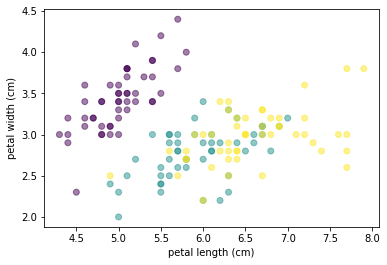

In [11]:
plt.scatter(iris.data[:,0], iris.data[:,1], c=iris.target, alpha=0.5, cmap='viridis')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.show()

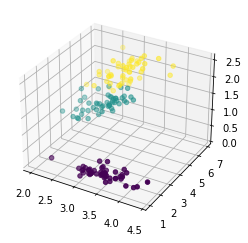

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=iris.data[:,1], ys=iris.data[:,2], zs=iris.data[:,3], zdir='z', s=20, c=iris.target,cmap='viridis')
plt.show()

## Example - a custom dataset

In [19]:
# test classification dataset
from sklearn.datasets import make_classification

# define dataset
# X = features values has shape-> (# samples, # features)  and y = labels or targets has shape (# samples,)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# summarize the dataset
print("X shape:", X.shape, "\ny shape:", y.shape)


X shape: (1000, 20) 
y shape: (1000,)


Next, we can use dimensionality reduction on this dataset while fitting a logistic regression model.

We will use a Pipeline where the first step performs the SVD transform and selects the 10 most important dimensions or components, then fits a logistic regression model on these features. We don’t need to normalize the variables on this dataset, as all variables have the same scale by design.

The pipeline will be evaluated using repeated stratified cross-validation with three repeats and 10 folds per repeat. Performance is presented as the mean classification accuracy.

In [25]:
# evaluate svd with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


# define the pipeline, svd select 10 components to reduce the original 20 dimentions
steps = [('svd', TruncatedSVD(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.814 (0.034)


>1 0.542 (0.046)
>2 0.626 (0.050)
>3 0.719 (0.053)
>4 0.722 (0.052)
>5 0.721 (0.054)
>6 0.729 (0.045)
>7 0.802 (0.034)
>8 0.800 (0.040)
>9 0.814 (0.037)
>10 0.814 (0.034)
>11 0.817 (0.037)
>12 0.820 (0.038)
>13 0.820 (0.036)
>14 0.825 (0.036)
>15 0.865 (0.027)
>16 0.865 (0.027)
>17 0.865 (0.027)
>18 0.865 (0.027)
>19 0.865 (0.027)


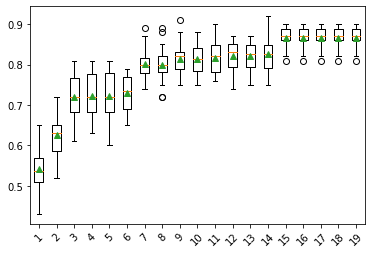

In [26]:
# compare svd number of components with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,20):
		steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

Interestingly, we don’t see any improvement **beyond 15 components**. This matches our definition of the problem where only the first 15 components contain information about the class and the remaining five are redundant.   

We may choose to use an SVD transform and logistic regression model combination as our final model.

This involves fitting the Pipeline on all available data and using the pipeline to make predictions on new data. Importantly, the same transform must be performed on this new data, which is handled automatically via the Pipeline.

The code below provides an example of fitting and using a final model with SVD transforms on new data.

In [27]:
# make predictions using svd with logistic regression
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model
steps = [('svd', TruncatedSVD(n_components=15)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [[0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]]
yhat = model.predict(row)
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1
